In [1]:
import numpy as np
import pandas as pd

SEED = 12345
np.random.seed(SEED)

# Load original dataset
- dataset can be obtained from https://grouplens.org/datasets/movielens/25m/
- place `ratings.csv` in `./data/` folder

In [2]:
DATA_FOLDER = "./data/"

In [3]:
ratings = pd.read_csv(DATA_FOLDER + "ratings.csv")

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
ratings["datetime"] = pd.to_datetime(ratings["timestamp"], unit = "s")

- rename `movieId` to `item_id`

In [6]:
ratings = ratings.rename(columns={"movieId": "item_id"})

In [7]:
ratings.sort_values(["userId","timestamp"], inplace=True)
ratings

,userId,item_id,rating,timestamp,datetime
36,1,5952,4.0,1147868053,2006-05-17 12:14:13
13,1,2012,2.5,1147868068,2006-05-17 12:14:28
12,1,2011,2.5,1147868079,2006-05-17 12:14:39
11,1,1653,4.0,1147868097,2006-05-17 12:14:57
9,1,1250,4.0,1147868414,2006-05-17 12:20:14
...,...,...,...,...,...
24999971,162541,1259,4.5,1240953609,2009-04-28 21:20:09
24999972,162541,1266,5.0,1240953613,2009-04-28 21:20:13
24999982,162541,1556,1.0,1240953650,2009-04-28 21:20:50
24999925,162541,293,4.0,1240953789,2009-04-28 21:23:09


In [8]:
ratings["sessionId"] = 1

<Axes: xlabel='datetime', ylabel='Count'>

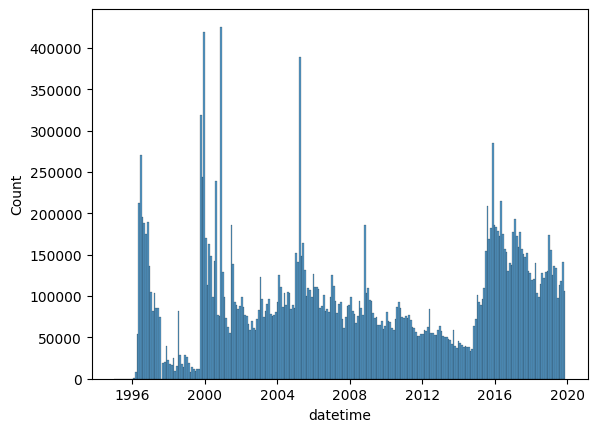

In [9]:
import seaborn as sns
sns.histplot(ratings["datetime"])

### Limit to only recent data (2015+)

In [10]:
ratings_recent = ratings.loc[ratings["datetime"] >= np.datetime64('2015', 'Y')]
ratings_recent.shape

(7563741, 6)

In [11]:
len(ratings_recent.item_id.unique()),len(ratings_recent.userId.unique())

(58133, 45450)

## Data binarization
- ratings < 2.5 are negative (-1), ratings > 3.5 are positive (+1); remove middle ones
- for testing, identify user-session pairs where there is at least three positive and three negative rating

In [12]:
df = ratings_recent.loc[~((ratings_recent.rating >=2.5)&(ratings_recent.rating <=3.5)) ]
df.shape

(4644545, 6)

In [13]:
df.loc[df.rating <2.5,"rating"] = -1
df.loc[df.rating >3.5,"rating"] = 1
df

,userId,item_id,rating,timestamp,datetime,sessionId
266,3,356,1.0,1439472199,2015-08-13 13:23:19,1
272,3,593,1.0,1439472203,2015-08-13 13:23:23,1
254,3,1,1.0,1439472215,2015-08-13 13:23:35,1
268,3,480,-1.0,1439472219,2015-08-13 13:23:39,1
317,3,2571,1.0,1439472221,2015-08-13 13:23:41,1
...,...,...,...,...,...,...
24999746,162538,69757,1.0,1438785456,2015-08-05 14:37:36,1
24999729,162538,49286,1.0,1438785469,2015-08-05 14:37:49,1
24999715,162538,8533,1.0,1438785506,2015-08-05 14:38:26,1
24999762,162538,93988,1.0,1438785545,2015-08-05 14:39:05,1


In [14]:
# create a user_session identifier
df = df.copy()
df['user_session_id'] = (df['userId'].astype(str) + '_' + df['sessionId'].astype(str))
df = df.sort_values(by=['user_session_id', 'timestamp'])

### Define sessions suitable for testing

In [15]:
testable_sessions = df.groupby('user_session_id').agg({"userId": "first", "rating": "count"}).rename(columns={"rating": "ratingsCount"}).reset_index()
testable_sessions["positiveCount"] = 0
positive_counts = df[df.rating == 1.].groupby('user_session_id').rating.count()
testable_sessions.loc[testable_sessions["user_session_id"].isin(positive_counts.index) ,"positiveCount"] = testable_sessions.loc[testable_sessions["user_session_id"].isin(positive_counts.index) ,"user_session_id"].apply(lambda x: positive_counts[x])
testable_sessions["negativeCount"] = testable_sessions["ratingsCount"] - testable_sessions["positiveCount"]

testable_sessions

,user_session_id,userId,ratingsCount,positiveCount,negativeCount
0,100001_1,100001,177,172,5
1,100007_1,100007,8,8,0
2,10000_1,10000,76,34,42
3,100014_1,100014,133,133,0
4,100016_1,100016,132,123,9
...,...,...,...,...,...
45406,99989_1,99989,26,18,8
45407,9998_1,9998,41,41,0
45408,99991_1,99991,112,75,37
45409,99999_1,99999,505,456,49


In [16]:
print(len(testable_sessions))
# we need at least 3 positive interactions and 3 negative interactions
testable_sessions = testable_sessions[(testable_sessions.positiveCount >= 3) & (testable_sessions.negativeCount >= 3)]
print(len(testable_sessions))

45411
25168


### Distinguish between validation and test sessions

In [17]:
# shuffle rows
testable_sessions = testable_sessions.sample(frac=1, random_state=SEED).reset_index(drop=True)
# add sessions randomly to validation set (0) or one of five CV splits (1-5)
testable_sessions["split"] = testable_sessions.index.values

split_number_to_string = {
    0: "val",  # 25% of sessions are validation
    1: "test",
    2: "test",
    3: "test",
}

testable_sessions["split"] = testable_sessions["split"].apply(lambda x: x % 4).apply(lambda x: split_number_to_string[x])

In [18]:
testable_sessions

,user_session_id,userId,ratingsCount,positiveCount,negativeCount,split
0,61898_1,61898,84,55,29,val
1,150129_1,150129,29,11,18,test
2,2730_1,2730,85,75,10,test
3,3492_1,3492,25,22,3,test
4,93712_1,93712,524,172,352,val
...,...,...,...,...,...,...
25163,21170_1,21170,332,325,7,test
25164,69118_1,69118,25,16,9,val
25165,112725_1,112725,181,116,65,test
25166,21529_1,21529,798,576,222,test


In [19]:
# check if every row is a unique user session
assert len(testable_sessions) == testable_sessions.user_session_id.nunique()

In [20]:
for split in ["train", "val", "test"]:
    print(f"number of testable sessions in split {split}: {len(testable_sessions[testable_sessions.split == split])}")

number of testable sessions in split train: 0
number of testable sessions in split val: 6292
number of testable sessions in split test: 18876


In [21]:
# map user_session_id to split
user_session_id_to_split = {usid: split for usid, split in zip(testable_sessions.user_session_id.values, testable_sessions.split.values)}

In [22]:
# assign dataframe entries to split
df["split"] = df["user_session_id"].apply(lambda x: user_session_id_to_split.get(x, "train"))

In [23]:
train_df = df[df.split == "train"]
eval_df = df[df.split != "train"]

# in training split, keep only interactions with (positive) rating 1
train_df = train_df[train_df.rating == 1.]

df = pd.concat([train_df, eval_df])

In [24]:
df.shape

(4625592, 8)

In [25]:
df.groupby("split")["rating"].count()

split
test     2683800
train    1037468
val       904324
Name: rating, dtype: int64

## Save processed dataset

In [26]:
df.to_csv(DATA_FOLDER + "ratings_processed_MovieLens_dense.csv", index=False)